In [1]:
import datetime

print(datetime.date.today())

2020-09-10


In [2]:
import torchvision
from torchvision import datasets, models, transforms
import os
import torch
import datetime
import time
import copy

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np

In [3]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()

print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.
Ready to use Azure ML 1.13.0 to work with Pycon2020


In [4]:
num_channels = 3
num_epochs = 2

model_save_path = 'durian.pth'

learning_rate = 0.001

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
from azureml.core import Datastore,Dataset

datastore = Datastore.get(ws, 'pycon2020_source_images')
planes_ds = Dataset.File.from_files((datastore, 'durian/*/*/*'))

In [7]:
import os

if os.name == 'nt':
    print ('Windows')
    data_dir = 'data'
else:
    print('Linux/Unix - can mount')
    # You can also use the start and stop methods
    mount_context = planes_ds.mount()

    mount_context.start()  # this will mount the file streams

    data_dir = mount_context.mount_point

Windows


In [8]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256, 256]),        
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ToTensor(),
    ])   
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4)
            for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

class_names = image_datasets['train'].classes

print('Classes loaded:',class_names)

num_letters = len(class_names)

Classes loaded: ['Durian', 'Jackfruit']


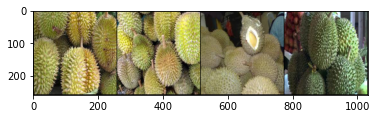

GroundTruth:  Durian Durian Durian Durian


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# for data in dataloaders['val']:
images, labels = next(iter(dataloaders['val']))#data

n_images = len(labels)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(n_images))) 


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    torch.save(model.state_dict(), model_save_path)

In [11]:
print('Started training')

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

print('Number of classes:',len(class_names))
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

print('Model trained.')

Started training
Number of classes: 2
Epoch 0/1
----------
train Loss: 0.5143 Acc: 0.6988
val Loss: 0.0561 Acc: 1.0000
Epoch 1/1
----------
train Loss: 0.2945 Acc: 0.8554
val Loss: 0.0569 Acc: 1.0000
Model trained.


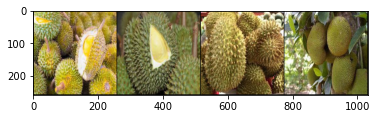

Ground Truth:  Durian Durian Durian Jackfruit
Predicted   :  Durian Durian Durian Jackfruit


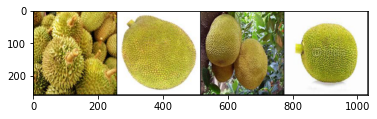

Ground Truth:  Durian Jackfruit Jackfruit Jackfruit
Predicted   :  Durian Jackfruit Jackfruit Jackfruit

Accuracy of the network on the test images: 100 %


In [13]:
# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

correct = 0
total = 0

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load(model_save_path), strict=False)
model.eval()

if torch.cuda.is_available():
    model.cuda()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        imshow(torchvision.utils.make_grid(inputs))
    
        print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(labels))))
        print('Predicted   : ', ' '.join('%5s' % class_names[preds[j]] for j in range(len(preds))))        
        
print('')
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total)) 